In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import keras_tuner as kt

In [3]:
# Download crypto data
cryptos = ['BTC-USD', 'ETH-USD', 'USDT-USD', 'BNB-USD', 'SOL-USD', 'XRP-USD', 'DX-Y.NYB']
data = yf.download(cryptos, start='2020-10-01', end='2024-10-01')
price_df = data['Adj Close']
price_df

[*********************100%***********************]  7 of 7 completed


Ticker,BNB-USD,BTC-USD,DX-Y.NYB,ETH-USD,SOL-USD,USDT-USD,XRP-USD
Date,,,,,,,
2020-10-01 00:00:00+00:00,27.431973,10619.452148,93.709999,353.205902,2.861028,1.000699,0.238249
2020-10-02 00:00:00+00:00,27.285681,10575.974609,93.839996,346.238922,2.626083,1.001049,0.234117
2020-10-03 00:00:00+00:00,28.202311,10549.329102,NaN,346.522095,2.547303,1.001108,0.232938
2020-10-04 00:00:00+00:00,28.943853,10669.583008,NaN,352.579010,2.515995,1.001359,0.247685
2020-10-05 00:00:00+00:00,28.659103,10793.339844,93.510002,353.956787,2.657644,1.000866,0.250816
...,...,...,...,...,...,...,...
2024-09-26 00:00:00+00:00,596.776917,65181.019531,100.559998,2632.199951,155.576096,1.000243,0.590421
2024-09-27 00:00:00+00:00,607.867004,65790.664062,100.419998,2695.900635,157.749939,1.000179,0.588927
2024-09-28 00:00:00+00:00,601.567200,65887.648438,NaN,2677.539062,156.912430,1.000186,0.614801


In [4]:

def get_data(ticker, df):
    """
    Extracts, computes log returns, and scales the specified ticker data.
    
    Parameters:
        ticker (str): The cryptocurrency ticker symbol (e.g., 'BTC-USD').
        df (DataFrame): The DataFrame containing adjusted close prices.
    
    Returns:
        scaled_data (ndarray): Scaled log returns data.
        scaler (MinMaxScaler): Fitted scaler object for inverse transformations.
    """
    # Select the ticker's price data and forward-fill missing values
    price_series = df[[ticker]].fillna(method='ffill')

    # Compute log returns to make the series stationary
    log_returns = np.log(price_series / price_series.shift(1)).dropna()

    # Initialize the MinMaxScaler and fit-transform the log returns
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(log_returns)

    return scaled_data, scaler

def inverse_transform_predictions(y_pred, scaler, price_series,ind):
    """
    Inverse transforms the scaled predictions and converts log returns back to prices.

    Parameters:
        y_pred (ndarray): Scaled predictions (log returns).
        scaler (MinMaxScaler): Fitted scaler for inverse transformation.
        price_series (DataFrame): Original price data to recover absolute prices.

    Returns:
        recovered_prices (ndarray): Recovered price predictions in original scale.
    """
    # Inverse scale the log returns
    log_returns_pred = scaler.inverse_transform(y_pred)

    # Recover prices from log returns
    last_price = price_series.iloc[ind].values[0]  # Last known price from the original series
    recovered_prices = last_price * np.exp(np.cumsum(log_returns_pred, axis=0))

    return recovered_prices



In [5]:

# Function to create sequences for LSTM
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)


In [6]:

# Define the hypermodel
def build_model(hp):
    model = Sequential()
    # Tune number of units in the first LSTM layer
    model.add(LSTM(
        units=hp.Int('units', min_value=32, max_value=128, step=32),
        activation='tanh',
        return_sequences=True,
        input_shape=(n_steps, 1)
    ))
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32), activation='tanh'))
    model.add(Dense(1))

    # Tune the learning rate
    learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    optimizer = Adam(learning_rate=learning_rate, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model



Processing BTC-USD...
Reloading Tuner from /tmp/BTC-USD/crypto_lstm/tuner0.json


/Users/yb/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/yb/anaconda3/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,705 (49.63 KB)

 Trainable params: 12,705 (49.63 KB)

 Non-trainable params: 0 (0.00 B)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
BTC-USD MSE: 0.00414
Processing ETH-USD...
Reloading Tuner from /tmp/ETH-USD/crypto_lstm/tuner0.json


/Users/yb/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/yb/anaconda3/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
ETH-USD MSE: 0.00622
Processing USDT-USD...
Reloading Tuner from /tmp/USDT-USD/crypto_lstm/tuner0.json


/Users/yb/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/yb/anaconda3/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
USDT-USD MSE: 0.00000
Processing BNB-USD...
Reloading Tuner from /tmp/BNB-USD/crypto_lstm/tuner0.json


/Users/yb/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/yb/anaconda3/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
BNB-USD MSE: 0.00381
Processing SOL-USD...
Reloading Tuner from /tmp/SOL-USD/crypto_lstm/tuner0.json


/Users/yb/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/yb/anaconda3/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 96)         │        37,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 96)             │        74,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,841 (436.88 KB)

 Trainable params: 111,841 (436.88 KB)

 Non-trainable params: 0 (0.00 B)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
SOL-USD MSE: 0.00803
Processing XRP-USD...
Reloading Tuner from /tmp/XRP-USD/crypto_lstm/tuner0.json


/Users/yb/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/yb/anaconda3/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 96)         │        37,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 96)             │        74,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,841 (436.88 KB)

 Trainable params: 111,841 (436.88 KB)

 Non-trainable params: 0 (0.00 B)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
XRP-USD MSE: 0.00278
Processing DX-Y.NYB...
Reloading Tuner from /tmp/DX-Y.NYB/crypto_lstm/tuner0.json


/Users/yb/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/yb/anaconda3/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
DX-Y.NYB MSE: 0.00004


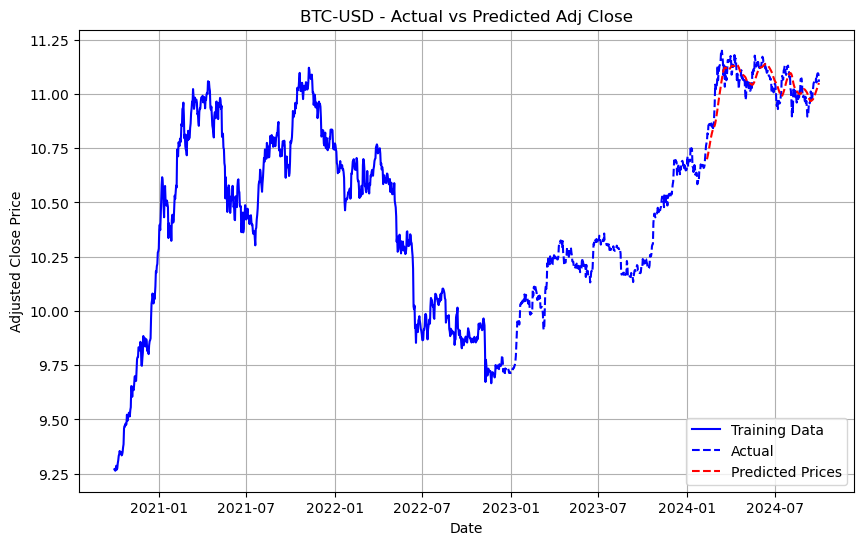

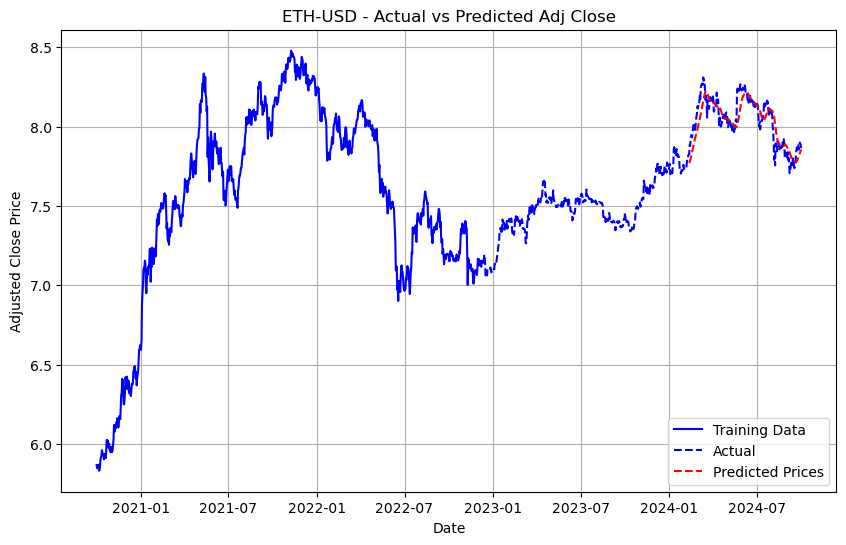

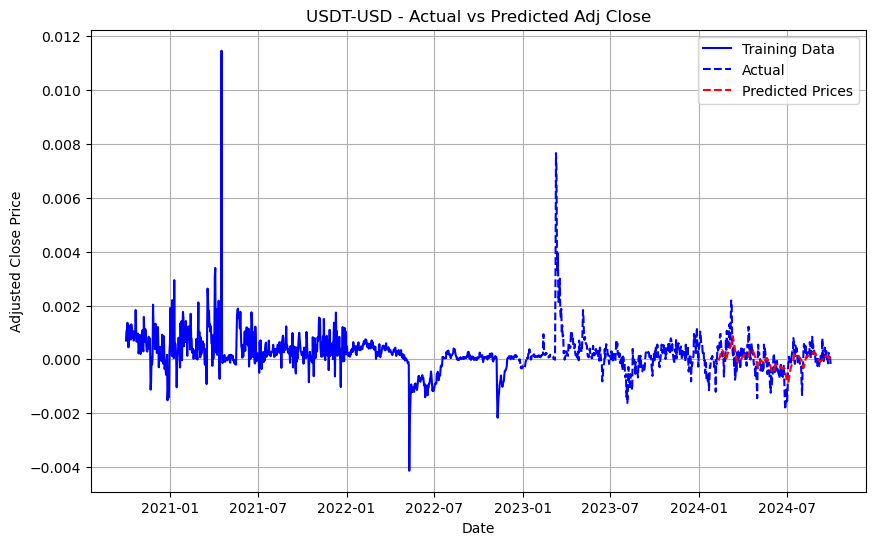

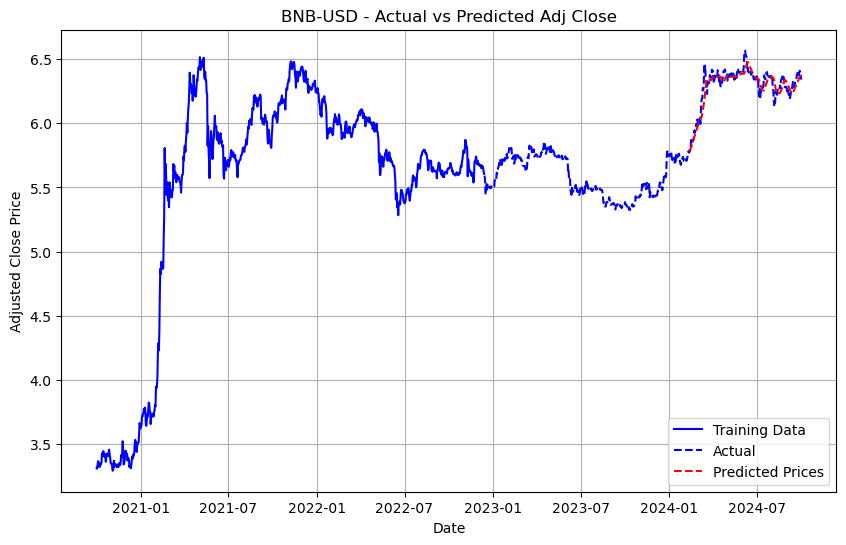

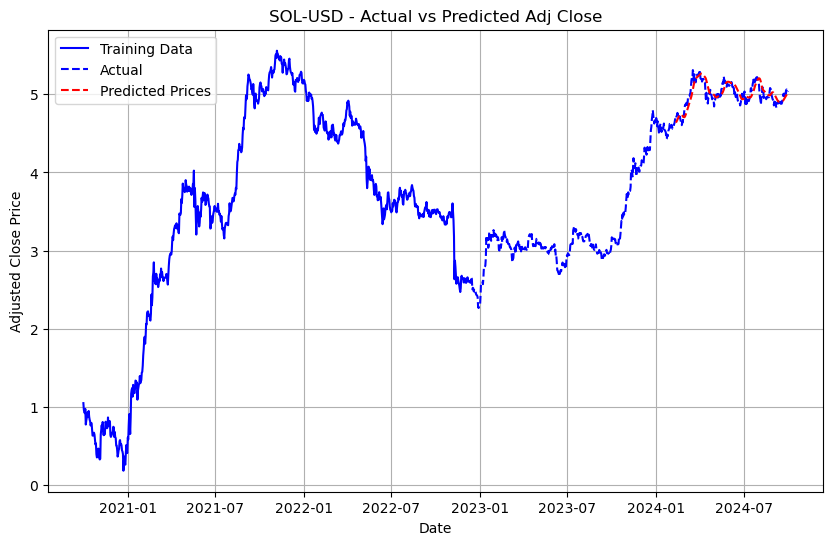

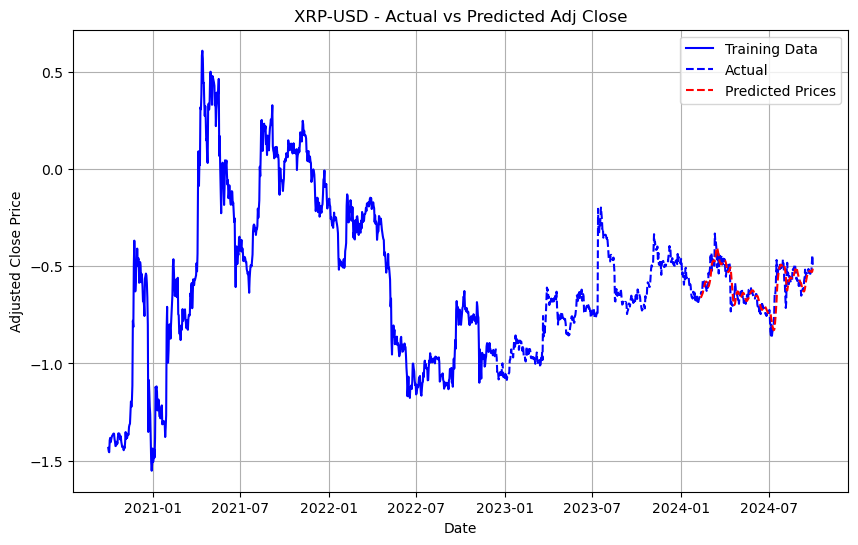

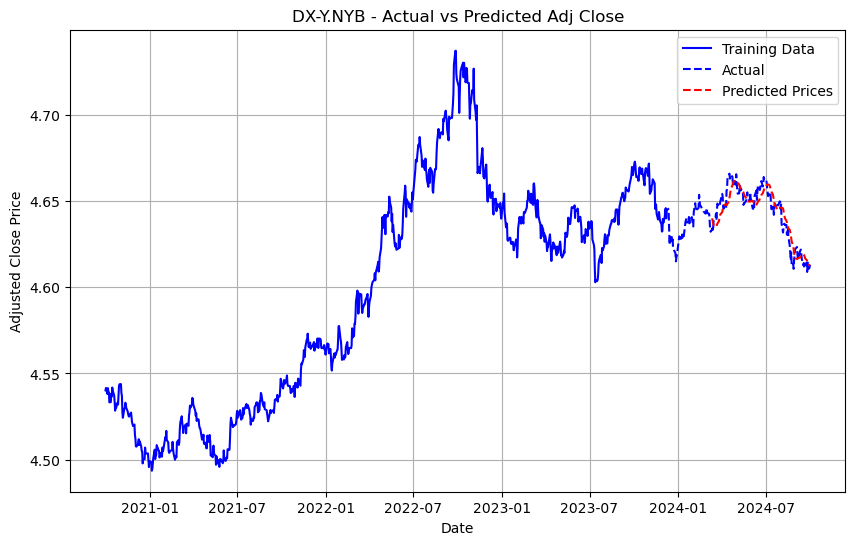

     Ticker           MSE
0   BTC-USD  4.136179e-03
1   ETH-USD  6.223616e-03
2  USDT-USD  2.080949e-07
3   BNB-USD  3.811646e-03
4   SOL-USD  8.028868e-03
5   XRP-USD  2.782769e-03
6  DX-Y.NYB  3.764235e-05


In [7]:



# Function to build the LSTM model with hyperparameter tuning
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32),
                   input_shape=(n_steps, 1), return_sequences=True))
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Store results to plot later
all_actuals = {}
all_predictions = {}
mse_results = {}

# Loop over each crypto ticker
for ticker in cryptos:
    print(f"Processing {ticker}...")

    # 1. Log Transformation
    log_transformed = np.log(price_df[ticker].dropna())

    # 2. Train-Test Split (80-20)
    train_size = int(len(log_transformed) * 0.8)
    train_data, test_data = log_transformed[:train_size], log_transformed[train_size:]

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))
    test_scaled = scaler.transform(test_data.values.reshape(-1, 1))

    # Create sequences for LSTM
    n_steps = 60  # Use a 60-day window
    X_train, y_train = create_sequences(train_scaled, n_steps)
    X_test, y_test = create_sequences(test_scaled, n_steps)

    # 3. Hyperparameter Tuning with Keras Tuner
    tuner = kt.RandomSearch(
        build_model,
        objective='val_loss',
        max_trials=3,  # Adjust as needed
        executions_per_trial=1,
        directory='/tmp/' + ticker,
        project_name='crypto_lstm'
    )

    tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
    best_model = tuner.get_best_models(num_models=1)[0]
    best_model.summary()

    # 4. Prediction and storing results for later plotting
    y_pred = best_model.predict(X_test)

    # Inverse transform the predictions
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test)

    # Calculate MSE and store it
    mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
    mse_results[ticker] = mse
    print(f'{ticker} MSE: {mse:.5f}')

    # Store predictions and actual values for later plotting
    all_actuals[ticker] = log_transformed
    all_predictions[ticker] = (train_size + n_steps, y_pred_rescaled.flatten())

# 5. After gathering all data, plot the results for each ticker
for ticker in cryptos:
    actual = all_actuals[ticker]
    start_idx, predictions = all_predictions[ticker]

    # Create a DataFrame for plotting the prediction starting at the correct index
    forecast_test = pd.DataFrame({'ds': actual.index[start_idx:], 'y': predictions})

    plt.figure(figsize=(10, 6))

    # Plot actual training data (blue line)
    plt.plot(actual.index[:train_size], actual[:train_size], label='Training Data', color='blue')

    # Plot actual test data (blue dashed line)
    plt.plot(actual.index[train_size:], actual[train_size:], label='Actual', color='blue', linestyle='--')

    # Plot predicted prices (red dashed line)
    plt.plot(forecast_test['ds'], forecast_test['y'], label='Predicted Prices', color='red', linestyle='--')

    # Add plot details
    plt.title(f'{ticker} - Actual vs Predicted Adj Close')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# 6. Create and display the MSE results table
mse_df = pd.DataFrame(list(mse_results.items()), columns=['Ticker', 'MSE'])
print(mse_df)


In [11]:
mse_df['rmse'] = np.sqrt(mse_df['MSE'])
print(mse_df)

     Ticker           MSE      rmse
0   BTC-USD  4.136179e-03  0.064313
1   ETH-USD  6.223616e-03  0.078890
2  USDT-USD  2.080949e-07  0.000456
3   BNB-USD  3.811646e-03  0.061739
4   SOL-USD  8.028868e-03  0.089604
5   XRP-USD  2.782769e-03  0.052752
6  DX-Y.NYB  3.764235e-05  0.006135
